In [49]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn import linear_model
from sklearn.linear_model import Ridge


random_param_test = 3
random_param_cv = 13

from sklearn.metrics import mean_absolute_error



In [2]:
df_full = pd.read_csv('student-por.csv', sep = ';')

display(df_full.head())

print("Shape is", df_full.shape )

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


Shape is (649, 33)


In [3]:
# Drop columns 'G1' and 'G2'. These are test scores from other periods. 
# The school requests a model that does not use these test scores to predict the 'G3' exam score.

df_full = df_full.drop(['G1','G2'], axis=1)

print("Shape is", df_full.shape )

Shape is (649, 31)


In [4]:
## Feature engineering: 
# We consider any category that contains less than 5% of students a rare category.
# We will now find the rare categories and bin the data to remove any rare categories.

# For each column, print the percentage of students who fall into each category:
for col in df_full.columns:
    print(col)
    print(df_full[col].value_counts()/649*100)
    print(' ')    
    print(' ')

school
GP    65.177196
MS    34.822804
Name: school, dtype: float64
 
 
sex
F    59.013867
M    40.986133
Name: sex, dtype: float64
 
 
age
17    27.580894
16    27.272727
18    21.571649
15    17.257319
19     4.930663
20     0.924499
21     0.308166
22     0.154083
Name: age, dtype: float64
 
 
address
U    69.645609
R    30.354391
Name: address, dtype: float64
 
 
famsize
GT3    70.416025
LE3    29.583975
Name: famsize, dtype: float64
 
 
Pstatus
T    87.673344
A    12.326656
Name: Pstatus, dtype: float64
 
 
Medu
2    28.659476
4    26.964561
1    22.033898
3    21.417565
0     0.924499
Name: Medu, dtype: float64
 
 
Fedu
2    32.203390
1    26.810478
3    20.184900
4    19.722650
0     1.078582
Name: Fedu, dtype: float64
 
 
Mjob
other       39.753467
services    20.955316
at_home     20.801233
teacher     11.093991
health       7.395994
Name: Mjob, dtype: float64
 
 
Fjob
other       56.548536
services    27.889060
at_home      6.471495
teacher      5.546995
health       3.543914

In [5]:
# age=19,20,21,22 are rare categories at 4.93, 0.92, 0.31, and 0.15 representation, respectively.
# We will group them into a single age '19'.
# Define the function for binning:

def get_age(N):
    
    if N<19 :
        return N
            
    else:
        return 19
    
# Create a new feature 'age_bin' 
df_full['age_bin'] = df_full['age'].apply(get_age)


In [6]:
# Since Medu=0 is a rare category with 0.92% representation, we will group it with the category '1'.
# Similarly for Fedu=0
# Define the function for binning:

def get_edu(N):
    
    if N<1 :
        return 1
            
    else:
        return N
    
# Create new features 'Medu_bin' and 'Fedu_bin' 

df_full['Medu_bin'] = df_full['Medu'].apply(get_edu)
df_full['Fedu_bin'] = df_full['Fedu'].apply(get_edu)


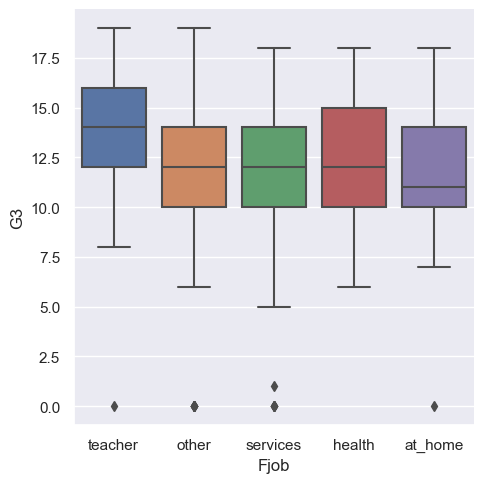

In [7]:
# Fjob = health is a rare category at 3.5% representation.
# From the following box plot, we see 'health' has a similar distribution as 'other', 
#    so we will group those categories together into the bin called 'other'.

sns.catplot(data=df_full, x="Fjob", y="G3", kind="box" )


def get_Fjob(N):
    
    if N=='health' :
        return 'other'
            
    else:
        return N
    
# Create a new feature 'Fjob_bin' 

df_full['Fjob_bin'] = df_full['Fjob'].apply(get_Fjob)



In [8]:
# traveltime = 4 is a rare category at 2.5% representation. 
# Combine traveltime = 3 and 4 to the category '3'.

def get_traveltime(N):
    
    if N>3 :
        return 3
            
    else:
        return N
    

# Create a new feature 'traveltime_bin' 

df_full['traveltime_bin'] = df_full['traveltime'].apply(get_traveltime)


In [9]:
# failures = 2,3 are a rare categories at 2.5% and 2.2% representation, respectively. 
# Combine failures = 1,2,3 to the category '1'.

def get_failures(N):
    
    if N>0 :
        return 1
            
    else:
        return N
    
# Create a new feature 'failures_bin' 

df_full['failures_bin'] = df_full['failures'].apply(get_failures)


In [10]:
# famrel = 1,2 are a rare categories at 4.5% and 3.5% representation, respectively. 
# Combine famrel = 1,2 into the category '2'.

def get_famrel(N):
    
    if N<3 :
        return 2
            
    else:
        return N
    
# Create a new feature 'famrel_bin' 

df_full['famrel_bin'] = df_full['famrel'].apply(get_famrel)


In [11]:
# Dalc = 4,5 are a rare categories at 2.6% representation each. 
# Combine Dalc = 4,5 into the category '4'.

def get_Dalc(N):
    
    if N>3 :
        return 4
            
    else:
        return N
    
# Create a new feature 'Dalc_bin' 

df_full['Dalc_bin'] = df_full['Dalc'].apply(get_Dalc)


In [12]:
# Lastly, we consider absences. 
# We see that mosts students have 0 absences. 

df_full['absences'].value_counts()

0     244
2     110
4      93
6      49
8      42
10     21
1      12
12     12
5      12
16     10
14      8
9       7
3       7
11      5
18      3
7       3
21      2
15      2
22      2
30      1
26      1
24      1
13      1
32      1
Name: absences, dtype: int64

In [13]:
# Since 244 students have 0 absences, we will choose to have 3 bins of size about 200.
# Define the function for binning:

def get_absences(N):
    
    if N == 0 :
        return 1
        
    elif N>0 and N<5 :
        return 2
    
    else:
        return 3
    
# Create a new feature 'absences_bin' that takes the three values:
# absences_bin = 1 if absences = 0
# absences_bin = 2 if absences = 1,2,3, or 4
# absences_bin = 3 if absences > 4

df_full['absences_bin'] = df_full['absences'].apply(get_absences)


# We see that the size of the bins are approximately 200

df_full['absences_bin'].value_counts()

1    244
2    222
3    183
Name: absences_bin, dtype: int64

In [14]:
# We have added 9 new binned features and are at a total of 40 columns.

df_full.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,G3,age_bin,Medu_bin,Fedu_bin,Fjob_bin,traveltime_bin,failures_bin,famrel_bin,Dalc_bin,absences_bin
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,11,18,4,4,teacher,2,0,4,1,2
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,11,17,1,1,other,1,0,5,1,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,12,15,1,1,other,1,0,4,2,3
3,GP,F,15,U,GT3,T,4,2,health,services,...,14,15,4,2,services,1,0,3,1,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,13,16,3,3,other,1,0,4,1,1


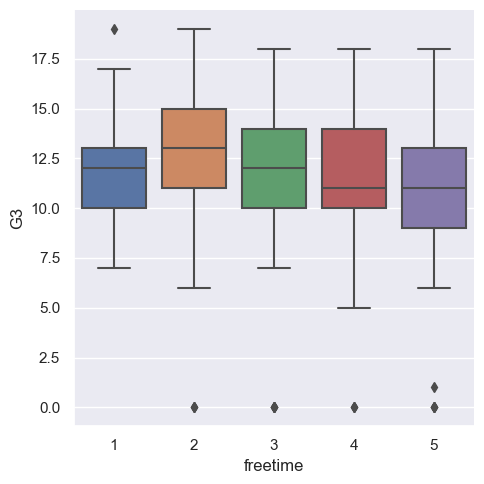

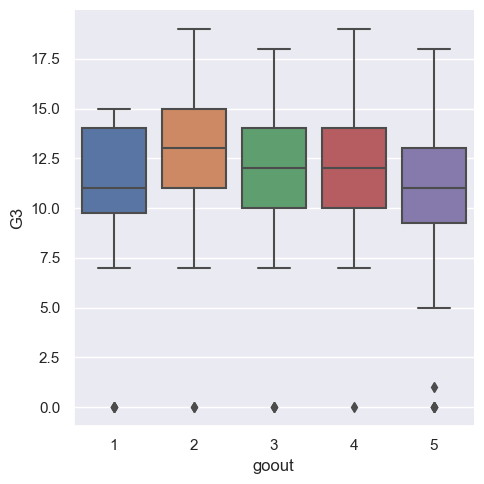

In [15]:
# Feature engineering: add polynomial features.

# 'freetime' and 'goout' should have a quadratic fit and not a linear fit. 
#     The reason behind this decision is that:  
#     Students who have very little free time (freetime = 1) score worse than students with some free time (freetime = 2).
#          That is, 'G3' increases from freetime=1 to freetime=2.
#     However, students with freetime > 2 see a monotonic decrease in their 'G3' score.
#     This behavior can be modelled well by a quadratic fit.
#     We demonstrate the behavior by showing the box plot for 'freetime' and 'goout'.
#          We see that the distribution of 'goout' behaves similarly to 'freetime'.

sns.catplot(data=df_full, x="freetime", y="G3", kind="box")

sns.catplot(data=df_full, x="goout", y="G3", kind="box")


In [16]:
# We now add those polynomial features 'freetime'^2 and 'goout'^2

df_full['freetime_squared'] = df_full['freetime']**2
df_full['goout_squared'] = df_full['goout']**2

# Adding these two columns brings us to 42 columns:
display(df_full.head())

print("Shape is", df_full.shape )

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Medu_bin,Fedu_bin,Fjob_bin,traveltime_bin,failures_bin,famrel_bin,Dalc_bin,absences_bin,freetime_squared,goout_squared
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,4,teacher,2,0,4,1,2,9,16
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,1,1,other,1,0,5,1,2,9,9
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,1,1,other,1,0,4,2,3,9,4
3,GP,F,15,U,GT3,T,4,2,health,services,...,4,2,services,1,0,3,1,1,4,4
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,3,other,1,0,4,1,1,9,4


Shape is (649, 42)


In [17]:
# Separate the binned and unbinned dataframes:

unbin_cols = ['age','Medu','Fedu','Fjob','traveltime','failures','famrel','Dalc','absences']

bin_cols = ['age_bin','Medu_bin','Fedu_bin','Fjob_bin','traveltime_bin','failures_bin','famrel_bin','Dalc_bin','absences_bin']

len(unbin_cols)

df_unbin = df_full.drop(bin_cols, axis=1).copy()
df_bin = df_full.drop(unbin_cols, axis=1).copy()



In [18]:
df_bin.head()

,school,sex,address,famsize,Pstatus,Mjob,reason,guardian,studytime,schoolsup,...,Medu_bin,Fedu_bin,Fjob_bin,traveltime_bin,failures_bin,famrel_bin,Dalc_bin,absences_bin,freetime_squared,goout_squared
0,GP,F,U,GT3,A,at_home,course,mother,2,yes,...,4,4,teacher,2,0,4,1,2,9,16
1,GP,F,U,GT3,T,at_home,course,father,2,no,...,1,1,other,1,0,5,1,2,9,9
2,GP,F,U,LE3,T,at_home,other,mother,2,yes,...,1,1,other,1,0,4,2,3,9,4
3,GP,F,U,GT3,T,health,home,mother,3,no,...,4,2,services,1,0,3,1,1,4,4
4,GP,F,U,GT3,T,other,home,father,2,no,...,3,3,other,1,0,4,1,1,9,4


In [19]:
# Preprocessing: one-hot encode the categorical features
enc_unbin = OneHotEncoder(handle_unknown='ignore',drop='first')

# Choose the categorical columns:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols_unbin = [cname for cname in df_unbin.columns if df_unbin[cname].nunique() < 10 and 
                        df_unbin[cname].dtype == "object"]

print(categorical_cols_unbin)

print(len(categorical_cols_unbin))

# -----------------------------------

# Preprocessing: one-hot encode the categorical features
enc_bin = OneHotEncoder(handle_unknown='ignore',drop='first')

# Choose the categorical columns:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols_bin = [cname for cname in df_bin.columns if df_bin[cname].nunique() < 10 and 
                        df_bin[cname].dtype == "object"]

print(categorical_cols_bin)

print(len(categorical_cols_bin))

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
17
['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'Fjob_bin']
17


In [20]:
# Extract the categorical_cols and apply one-hot

df_unbin_onehot = df_full[categorical_cols_unbin].copy()

enc_unbin.fit(df_unbin_onehot)

enc_unbin.categories_

[array(['GP', 'MS'], dtype=object),
 array(['F', 'M'], dtype=object),
 array(['R', 'U'], dtype=object),
 array(['GT3', 'LE3'], dtype=object),
 array(['A', 'T'], dtype=object),
 array(['at_home', 'health', 'other', 'services', 'teacher'], dtype=object),
 array(['at_home', 'health', 'other', 'services', 'teacher'], dtype=object),
 array(['course', 'home', 'other', 'reputation'], dtype=object),
 array(['father', 'mother', 'other'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object)]

In [21]:
# Extract the categorical_cols and apply one-hot

df_bin_onehot = df_full[categorical_cols_bin].copy()

enc_bin.fit(df_bin_onehot)

enc_bin.categories_

[array(['GP', 'MS'], dtype=object),
 array(['F', 'M'], dtype=object),
 array(['R', 'U'], dtype=object),
 array(['GT3', 'LE3'], dtype=object),
 array(['A', 'T'], dtype=object),
 array(['at_home', 'health', 'other', 'services', 'teacher'], dtype=object),
 array(['course', 'home', 'other', 'reputation'], dtype=object),
 array(['father', 'mother', 'other'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['at_home', 'other', 'services', 'teacher'], dtype=object)]

In [22]:
df_unbin_onehot = pd.DataFrame(enc_unbin.transform(df_unbin_onehot).toarray())
df_bin_onehot = pd.DataFrame(enc_bin.transform(df_bin_onehot).toarray())

In [23]:
col_unbin_onehot = enc_unbin.get_feature_names_out()

df_unbin_onehot.columns = col_unbin_onehot

display(df_unbin_onehot.head())

print("Shape is", df_unbin_onehot.shape )

# -----------------------------------

col_bin_onehot = enc_bin.get_feature_names_out()

df_bin_onehot.columns = col_bin_onehot

display(df_bin_onehot.head())

print("Shape is", df_bin_onehot.shape )

,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


Shape is (649, 26)


,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,reason_home,...,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,Fjob_bin_other,Fjob_bin_services,Fjob_bin_teacher
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


Shape is (649, 25)


In [24]:
# Now drop the categorical_cols and add in the onehot encoded:

df_unbin = df_unbin.drop(categorical_cols_unbin, axis=1).copy()

df_unbin = df_unbin.merge(df_unbin_onehot, how='left', left_index=True, right_index=True)

df_unbin.head(10)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,17,1,1,1,2,0,5,3,3,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,15,1,1,1,2,0,4,3,2,2,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,15,4,2,1,3,0,3,2,2,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
4,16,3,3,1,2,0,4,3,2,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
5,16,4,3,1,2,0,5,4,2,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
6,16,2,2,1,2,0,4,4,4,1,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
7,17,4,4,2,2,0,4,1,4,1,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
8,15,3,2,1,2,0,4,2,2,1,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
9,15,3,4,1,2,0,5,5,1,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0


In [25]:
df_unbin.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                649 non-null    int64  
 1   Medu               649 non-null    int64  
 2   Fedu               649 non-null    int64  
 3   traveltime         649 non-null    int64  
 4   studytime          649 non-null    int64  
 5   failures           649 non-null    int64  
 6   famrel             649 non-null    int64  
 7   freetime           649 non-null    int64  
 8   goout              649 non-null    int64  
 9   Dalc               649 non-null    int64  
 10  Walc               649 non-null    int64  
 11  health             649 non-null    int64  
 12  absences           649 non-null    int64  
 13  G3                 649 non-null    int64  
 14  freetime_squared   649 non-null    int64  
 15  goout_squared      649 non-null    int64  
 16  school_MS          649 non

In [26]:
# Now drop the categorical_cols and add in the onehot encoded:

df_bin = df_bin.drop(categorical_cols_bin, axis=1).copy()

df_bin = df_bin.merge(df_bin_onehot, how='left', left_index=True, right_index=True)

df_bin.head(10)

,studytime,freetime,goout,Walc,health,G3,age_bin,Medu_bin,Fedu_bin,traveltime_bin,...,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,Fjob_bin_other,Fjob_bin_services,Fjob_bin_teacher
0,2,3,4,1,3,11,18,4,4,2,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2,3,3,1,3,11,17,1,1,1,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,2,3,2,3,3,12,15,1,1,1,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
3,3,2,2,1,5,14,15,4,2,1,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,2,3,2,2,5,13,16,3,3,1,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
5,2,4,2,2,5,13,16,4,3,1,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
6,2,4,4,1,3,13,16,2,2,1,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
7,2,1,4,1,1,13,17,4,4,2,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
8,2,2,2,1,1,17,15,3,2,1,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
9,2,5,1,1,5,13,15,3,4,1,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0


In [27]:
df_bin.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   studytime          649 non-null    int64  
 1   freetime           649 non-null    int64  
 2   goout              649 non-null    int64  
 3   Walc               649 non-null    int64  
 4   health             649 non-null    int64  
 5   G3                 649 non-null    int64  
 6   age_bin            649 non-null    int64  
 7   Medu_bin           649 non-null    int64  
 8   Fedu_bin           649 non-null    int64  
 9   traveltime_bin     649 non-null    int64  
 10  failures_bin       649 non-null    int64  
 11  famrel_bin         649 non-null    int64  
 12  Dalc_bin           649 non-null    int64  
 13  absences_bin       649 non-null    int64  
 14  freetime_squared   649 non-null    int64  
 15  goout_squared      649 non-null    int64  
 16  school_MS          649 non

In [28]:
corr_matrix_unbin = df_unbin.corr()

corr_matrix_unbin

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
age,1.000000,-0.107832,-0.121050,0.034490,-0.008415,0.319968,-0.020559,-0.004910,0.112805,0.134768,...,-0.048726,0.330353,-0.167841,-0.101894,-0.005458,-0.054279,-0.021441,-0.265497,0.013115,0.178810
Medu,-0.107832,1.000000,0.647477,-0.265079,0.097006,-0.172210,0.024421,-0.019686,0.009536,-0.007018,...,0.091562,-0.101123,-0.022168,0.120491,0.113973,0.119354,0.125951,0.213896,0.266052,-0.030992
Fedu,-0.121050,0.647477,1.000000,-0.208288,0.050400,-0.165915,0.020256,0.006841,0.027690,0.000061,...,-0.044450,-0.066684,0.023572,0.135191,0.094628,0.079700,0.074863,0.191735,0.183483,-0.067675
traveltime,0.034490,-0.265079,-0.208288,1.000000,-0.063154,0.097730,-0.009521,0.000937,0.057454,0.092824,...,-0.066130,0.090497,-0.044807,-0.039289,-0.044842,-0.033376,-0.011509,-0.071958,-0.190826,0.004751
studytime,-0.008415,0.097006,0.050400,-0.063154,1.000000,-0.147441,-0.004127,-0.068829,-0.075442,-0.137585,...,-0.018076,0.006440,0.089316,0.143509,-0.002314,0.070080,0.042630,0.188256,0.037529,0.033036
failures,0.319968,-0.172210,-0.165915,0.097730,-0.147441,1.000000,-0.062645,0.108995,0.045078,0.105949,...,-0.056527,0.234027,-0.000745,-0.006982,0.069416,0.000561,-0.069241,-0.309400,-0.095330,0.069901
famrel,-0.020559,0.024421,0.020256,-0.009521,-0.004127,-0.062645,1.000000,0.129216,0.089707,-0.075767,...,0.012507,-0.067365,-0.012038,0.015228,0.031937,0.057597,0.041055,0.048239,0.082214,-0.044920
freetime,-0.004910,-0.019686,0.006841,0.000937,-0.068829,0.108995,0.129216,1.000000,0.346352,0.109904,...,0.022349,0.033823,-0.015611,0.003764,-0.049574,0.150329,-0.007096,-0.102618,0.063268,0.027112
goout,0.112805,0.009536,0.027690,0.057454,-0.075442,0.045078,0.089707,0.346352,1.000000,0.245126,...,0.042602,0.018432,-0.058124,0.017262,-0.006683,0.088582,0.018679,-0.069105,0.092869,-0.000520
Dalc,0.134768,-0.007018,0.000061,0.092824,-0.137585,0.105949,-0.075767,0.109904,0.245126,1.000000,...,-0.093064,0.112437,-0.028076,-0.016844,0.051986,0.022592,-0.078376,-0.131663,0.042811,0.062042


In [29]:
corr_matrix_unbin['G3']

age                 -0.106505
Medu                 0.240151
Fedu                 0.211800
traveltime          -0.127173
studytime            0.249789
failures            -0.393316
famrel               0.063361
freetime            -0.122705
goout               -0.087641
Dalc                -0.204719
Walc                -0.176619
health              -0.098851
absences            -0.091379
G3                   1.000000
freetime_squared    -0.139009
goout_squared       -0.116278
school_MS           -0.284294
sex_M               -0.129077
address_U            0.167637
famsize_LE3          0.045016
Pstatus_T           -0.000754
Mjob_health          0.101244
Mjob_other          -0.059251
Mjob_services        0.038447
Mjob_teacher         0.134910
Fjob_health          0.039142
Fjob_other          -0.005301
Fjob_services       -0.053204
Fjob_teacher         0.125916
reason_home          0.046537
reason_other        -0.132577
reason_reputation    0.170944
guardian_mother     -0.004415
guardian_o

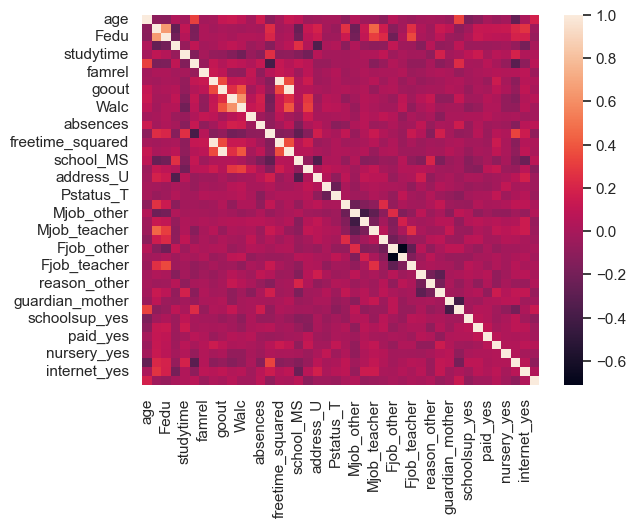

In [30]:
sns.heatmap(corr_matrix_unbin)
plt.show()

In [31]:
corr_matrix_bin = df_bin.corr()

corr_matrix_bin

,studytime,freetime,goout,Walc,health,G3,age_bin,Medu_bin,Fedu_bin,traveltime_bin,...,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,Fjob_bin_other,Fjob_bin_services,Fjob_bin_teacher
studytime,1.000000,-0.068829,-0.075442,-0.214925,-0.056433,0.249789,-0.005447,0.094146,0.048631,-0.077861,...,0.143509,-0.002314,0.070080,0.042630,0.188256,0.037529,0.033036,0.000158,0.014716,-0.020335
freetime,-0.068829,1.000000,0.346352,0.120244,0.084526,-0.122705,-0.007221,-0.018773,0.006599,0.000780,...,0.003764,-0.049574,0.150329,-0.007096,-0.102618,0.063268,0.027112,0.029035,-0.051132,0.003269
goout,-0.075442,0.346352,1.000000,0.388680,-0.015741,-0.087641,0.118395,0.007202,0.022940,0.049551,...,0.017262,-0.006683,0.088582,0.018679,-0.069105,0.092869,-0.000520,0.050587,-0.027686,-0.038139
Walc,-0.214925,0.120244,0.388680,1.000000,0.114988,-0.176619,0.083736,-0.017569,0.029129,0.047613,...,-0.065605,0.035682,0.032824,-0.075748,-0.084327,0.060651,-0.019971,-0.025419,0.102381,-0.084424
health,-0.056433,0.084526,-0.015741,0.114988,1.000000,-0.098851,-0.006428,0.007339,0.047870,-0.053672,...,0.018803,0.063203,0.013001,0.001701,0.017290,-0.022792,-0.018025,0.084647,-0.076209,0.017218
G3,0.249789,-0.122705,-0.087641,-0.176619,-0.098851,1.000000,-0.101605,0.243103,0.216044,-0.128135,...,0.059206,-0.054898,0.059791,0.028752,0.332172,0.150025,-0.090583,0.009412,-0.053204,0.125916
age_bin,-0.005447,-0.007221,0.118395,0.083736,-0.006428,-0.101605,1.000000,-0.109267,-0.115296,0.053173,...,-0.095738,-0.018063,-0.058578,-0.020967,-0.253462,0.007370,0.172647,0.017744,-0.026793,-0.052449
Medu_bin,0.094146,-0.018773,0.007202,-0.017569,0.007339,0.243103,-0.109267,1.000000,0.650756,-0.267210,...,0.120356,0.113573,0.118609,0.121524,0.215452,0.264767,-0.037771,-0.060035,-0.017909,0.259964
Fedu_bin,0.048631,0.006599,0.022940,0.029129,0.047870,0.216044,-0.115296,0.650756,1.000000,-0.207274,...,0.133649,0.093675,0.077036,0.081049,0.198356,0.185273,-0.064595,-0.130351,0.020811,0.352242
traveltime_bin,-0.077861,0.000780,0.049551,0.047613,-0.053672,-0.128135,0.053173,-0.267210,-0.207274,1.000000,...,-0.044031,-0.040105,-0.028669,-0.019214,-0.084191,-0.186714,0.000022,0.064099,-0.027488,-0.045280


In [32]:
corr_matrix_bin['G3']

studytime            0.249789
freetime            -0.122705
goout               -0.087641
Walc                -0.176619
health              -0.098851
G3                   1.000000
age_bin             -0.101605
Medu_bin             0.243103
Fedu_bin             0.216044
traveltime_bin      -0.128135
failures_bin        -0.438403
famrel_bin           0.054619
Dalc_bin            -0.210478
absences_bin        -0.060863
freetime_squared    -0.139009
goout_squared       -0.116278
school_MS           -0.284294
sex_M               -0.129077
address_U            0.167637
famsize_LE3          0.045016
Pstatus_T           -0.000754
Mjob_health          0.101244
Mjob_other          -0.059251
Mjob_services        0.038447
Mjob_teacher         0.134910
reason_home          0.046537
reason_other        -0.132577
reason_reputation    0.170944
guardian_mother     -0.004415
guardian_other      -0.080729
schoolsup_yes       -0.066405
famsup_yes           0.059206
paid_yes            -0.054898
activities

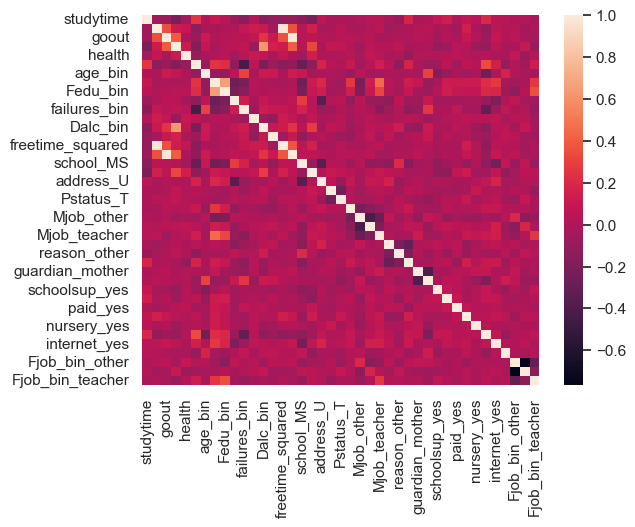

In [33]:
sns.heatmap(corr_matrix_bin)
plt.show()

In [34]:
#Dropping outliers: 
#Remove the 15 students who did not take the G3 exam. This includes 15 students, or 2.3% of the total population.

df_out_bin = df_bin.loc[ df_bin['G3'] != 0 ]

display(df_out_bin.shape)

# -----------------------------------

df_out_unbin = df_unbin.loc[ df_unbin['G3'] != 0 ]

display(df_out_unbin.shape)



(634, 41)

(634, 42)

In [35]:
# Modeling
# We have 4 datasets: df_bin, df_unbin, df_out_bin, and df_out_unbin
# We will consider two models applied to the above data sets: 
#     Linear Regression (with Lasso and Ridge regularization) and Random Forest Regression
# We compare the performance of these models against the benchmarks:
#     Predict every student scored the average score
#     Linear regression using one feature, 'failures'. 
#          We chose 'failures' because it is the feature that has the highest correlation with 'G3': correl = -0.39



# Separate target from predictors

y_unbin = df_unbin.G3
X_unbin = df_unbin.drop(['G3'], axis=1)
# -----------------------------------
y_bin = df_bin.G3
X_bin = df_bin.drop(['G3'], axis=1)
# -----------------------------------
y_out_unbin = df_out_unbin.G3
X_out_unbin = df_out_unbin.drop(['G3'], axis=1)
# -----------------------------------
y_out_bin = df_out_bin.G3
X_out_bin = df_out_bin.drop(['G3'], axis=1)


In [36]:
# Divide data into training and test subsets

X_unbin_train, X_unbin_test, y_unbin_train, y_unbin_test = train_test_split(X_unbin, y_unbin, train_size=0.8, test_size=0.2,
                                                                random_state=random_param_test)
# -----------------------------------
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y_bin, train_size=0.8, test_size=0.2,
                                                                random_state=random_param_test)
# -----------------------------------
X_out_unbin_train, X_out_unbin_test, y_out_unbin_train, y_out_unbin_test = train_test_split(X_out_unbin, y_out_unbin, train_size=0.8, test_size=0.2,
                                                                random_state=random_param_test)
# -----------------------------------
X_out_bin_train, X_out_bin_test, y_out_bin_train, y_out_bin_test = train_test_split(X_out_bin, y_out_bin, train_size=0.8, test_size=0.2,
                                                                random_state=random_param_test)

In [37]:
# We begin with the first benchmark, predicting every student scored the average.

def Average(lst):
    return sum(lst) / len(lst)

avg_unbin = Average(y_unbin_train)
print("Average is %.2f" % avg_unbin)
# -----------------------------------
avg_bin = Average(y_bin_train)
#display(avg_bin)
# -----------------------------------
avg_out_unbin = Average(y_out_unbin_train)
print("Dropping outliers, the average is %.2f" % avg_out_unbin)
# -----------------------------------
avg_out_bin = Average(y_out_bin_train)
#display(avg_out_bin)
# -----------------------------------


ones_len_test = [1]*len(y_unbin_test)
ones_out_len_test = [1]*len(y_out_unbin_test)


y_unbin_pred_avg = [x * avg_unbin for x in ones_len_test]
# -----------------------------------
y_bin_pred_avg = y_unbin_pred_avg.copy()
# -----------------------------------
y_out_unbin_pred_avg = [x * avg_out_unbin for x in ones_out_len_test]
# -----------------------------------
y_out_bin_pred_avg = y_out_unbin_pred_avg.copy()
# -----------------------------------

print('')
print('We use mean absolute error to score the models:')

print("MAE of pred_avg unbin: %.2f" % mean_absolute_error(y_unbin_test, y_unbin_pred_avg))
# -----------------------------------
print("MAE of pred_avg bin: %.2f" % mean_absolute_error(y_bin_test, y_bin_pred_avg))
# -----------------------------------
print("MAE of pred_avg out_unbin: %.2f" % mean_absolute_error(y_out_unbin_test, y_out_unbin_pred_avg))
# -----------------------------------
print("MAE of pred_avg out_bin: %.2f" % mean_absolute_error(y_out_bin_test, y_out_bin_pred_avg))
# -----------------------------------


Average is 11.87
Dropping outliers, the average is 12.20

We use mean absolute error to score the models:
MAE of pred_avg unbin: 2.29
MAE of pred_avg bin: 2.29
MAE of pred_avg out_unbin: 2.18
MAE of pred_avg out_bin: 2.18


In [38]:
# We now compute the second benchmark, linear regression using 'failures' or 'failures_bin'.

model_LinReg_failures_unbin = linear_model.LinearRegression()
# -----------------------------------
model_LinReg_failures_bin = linear_model.LinearRegression()
# -----------------------------------
model_LinReg_failures_out_unbin = linear_model.LinearRegression()
# -----------------------------------
model_LinReg_failures_out_bin = linear_model.LinearRegression()


cols_unbin = ['failures','G3']
# -----------------------------------
cols_bin = ['failures_bin','G3']


#df_subset_1 = df[failures_G3].copy()



In [84]:
# Modeling
# We have 4 datasets: df_bin, df_unbin, df_out_bin, and df_out_unbin .
# We will consider two models applied to the above data sets: 
#     Linear Regression (with Lasso and Ridge regularization) and Random Forest Regression
# We compare the performance of these models against the benchmarks:
#     Bench1: Predict every student scored the average score.
#     Bench2: Linear regression using one feature, 'failures'. 
#          We choose to use 'failures' because it is the feature that has the highest correlation with 'G3': correl = -0.39

for dataset in range(1,5):
    if dataset == 1:
        df = df_unbin
        print('Results for df_unbin:')
    elif dataset == 2:
        df = df_bin
        print('Results for df_bin:')
    elif dataset == 3:
        df = df_out_unbin
        print('Results for df_out_unbin:')
    else:
        df = df_out_bin
        print('Results for df_out_bin:')
    
    # Separate target from predictors
    y = df.G3
    X = df.drop(['G3'], axis=1)
    
    # Divide data into training and test subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                    random_state=random_param_test)
    
    ## Bench 1: Predicting every student scored the average.
    def Average(lst):
        return sum(lst) / len(lst)

    avg = Average(y_train)
    #print("Average is %.2f" % avg)
    
    ones_len_test = [1]*len(y_test)
    y_pred_avg = [x * avg for x in ones_len_test]
    print("Bench 1, pred_avg MAE: %.2f" % mean_absolute_error(y_test, y_pred_avg))
    
    
    ## Bench 2: Linear regression using 'failures' or 'failures_bin'.
    model_LinReg_failures = linear_model.LinearRegression()
    cols_unbin = ['failures','G3']
    cols_bin = ['failures_bin','G3']    
    if dataset == 1:        
        df_failures = df[cols_unbin].copy()
    elif dataset == 2:      
        df_failures = df[cols_bin].copy()
    elif dataset == 3:        
        df_failures = df[cols_unbin].copy()
    else:        
        df_failures = df[cols_bin].copy()
    # Separate target from predictors
    y_failures = df_failures.G3
    X_failures = df_failures.drop(['G3'], axis=1)
    # Divide data into training and test subsets
    X_failures_train, X_failures_test, y_failures_train, y_failures_test = train_test_split(X_failures, y_failures, train_size=0.8, test_size=0.2,
                                                                    random_state=random_param_test)
    model_LinReg_failures.fit(X_failures_train, y_failures_train)
    # Make predictions using the testing set
    y_pred_failures = model_LinReg_failures.predict(X_failures_test)
    # The mean absolute error
    print("Bench 2, pred_failures MAE: %.2f" % mean_absolute_error(y_failures_test, y_pred_failures))
    
    
    ## Model 1: Linear regression with all features
    model_LinReg = linear_model.LinearRegression()
    model_LinReg.fit(X_train, y_train)
    y_pred_LinReg = model_LinReg.predict(X_test)
    print("Model 1, lin reg MAE: %.2f" % mean_absolute_error(y_test, y_pred_LinReg))
    #print(model_LinReg.coef_.round(1))

    
    ## Model 1a: Linear regression with Lasso Regularization
    clf = linear_model.Lasso(alpha=.1)
    clf.fit(X_train, y_train)
    y_pred_Lasso = clf.predict(X_test)
    print("Model 1a, Lasso MAE: %.2f" % mean_absolute_error(y_test, y_pred_Lasso))
    # print(clf.coef_.round(1))
    
    
    ## Hyperparameter tuning for Lasso:
    
    # Divide data into training and test subsets
    X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2,
                                                                    random_state=random_param_test)
    # Set up grid for regularization parameter
    exponents = np.arange(1,100)
    lambdas = 10 * 0.90 ** exponents

    # Instantiate MAE
    MAE = 10
    
    # Lasso regression for each regularization parameter in grid
    for lambda_j in lambdas:
        lr_j = linear_model.Lasso(lambda_j)
        lr_j.fit(X_train2, y_train2)
        y_val_pred_j = lr_j.predict(X_valid)
        MAE_j = mean_absolute_error(y_valid, y_val_pred_j)
        if MAE_j < MAE:
            lr = lr_j
            MAE = MAE_j
            
    y_pred_Tuned_Lasso = lr.predict(X_test)
    print("     Model 1a tuned, Lasso MAE: %.2f" % mean_absolute_error(y_test, y_pred_Tuned_Lasso))
    print("     Optimal alpha = %.2f" % lr.get_params()['alpha'])
    
    
    ## Model 1b: Linear regression with Ridge Regularization
    clf2 = Ridge(alpha=1)
    clf2.fit(X_train, y_train)
    y_pred_Ridge = clf2.predict(X_test)
    print("Model 1b, Ridge MAE: %.2f" % mean_absolute_error(y_test, y_pred_Ridge))
    #print(clf2.coef_.round(1))
    #print( (clf2.coef_ - model_LinReg.coef_).round(2) )

    
    ## Hyperparameter tuning for Ridge:
    
    lambdas_Ridge = np.arange(1,100)
  
    # Instantiate MAE
    MAE = 10
    
    # Ridge regression for each regularization parameter in grid
    for lambda_j in lambdas_Ridge:
        lr_j = linear_model.Ridge(lambda_j)
        lr_j.fit(X_train2, y_train2)
        y_val_pred_j = lr_j.predict(X_valid)
        MAE_j = mean_absolute_error(y_valid, y_val_pred_j)
        if MAE_j < MAE:
            lr_Ridge = lr_j
            MAE = MAE_j
            
    y_pred_Tuned_Ridge = lr_Ridge.predict(X_test)
    print("     Model 1b tuned, Ridge MAE: %.2f" % mean_absolute_error(y_test, y_pred_Tuned_Ridge))
    print("     Optimal alpha = %.2f" % lr_Ridge.get_params()['alpha'])
    
    
    
    
    
    
    ## Model 2: Random Forest Regressor
    model_Forest = RandomForestRegressor(random_state=0)
    model_Forest.fit(X_train, y_train)
    y_pred_Forest = model_Forest.predict(X_test)
    print("Model 2, forest MAE: %.2f" % mean_absolute_error(y_test, y_pred_Forest))

    
    
    print('')

Results for df_unbin:
Bench 1, pred_avg MAE: 2.29
Bench 2, pred_failures MAE: 2.17
Model 1, lin reg MAE: 1.90
Model 1a, Lasso MAE: 2.00
     Model 1a tuned, Lasso MAE: 1.93
     Optimal alpha = 0.05
Model 1b, Ridge MAE: 1.90
     Model 1b tuned, Ridge MAE: 1.93
     Optimal alpha = 37.00
Model 2, forest MAE: 1.89

Results for df_bin:
Bench 1, pred_avg MAE: 2.29
Bench 2, pred_failures MAE: 2.13
Model 1, lin reg MAE: 1.88
Model 1a, Lasso MAE: 1.94
     Model 1a tuned, Lasso MAE: 1.90
     Optimal alpha = 0.06
Model 1b, Ridge MAE: 1.88
     Model 1b tuned, Ridge MAE: 1.91
     Optimal alpha = 34.00
Model 2, forest MAE: 1.87

Results for df_out_unbin:
Bench 1, pred_avg MAE: 2.18
Bench 2, pred_failures MAE: 2.10
Model 1, lin reg MAE: 1.66
Model 1a, Lasso MAE: 1.81
     Model 1a tuned, Lasso MAE: 1.69
     Optimal alpha = 0.02
Model 1b, Ridge MAE: 1.66
     Model 1b tuned, Ridge MAE: 1.68
     Optimal alpha = 24.00
Model 2, forest MAE: 1.82

Results for df_out_bin:
Bench 1, pred_avg MAE: 2.1